#  Ranking by Collaborative Filtering - Minimal Implementation
Implementation by Kamil Ciosek

This file implements two popular methods for collaborative filtering. It is intended to be self-contained and was written for educational purposes.
 - PureSVD, which imputes all unknown rankings to be zero and then performs a Singular Value Decomposition 
 - A recommender performing gradient descent on equation (4) from the paper [Probabilistic Matrix Factorization](https://papers.nips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf) by R. Salakhutdinov and A. Mnih, where there is no imputation, i.e. the loss only incldues the known entries of the ranking matrix.
 
The evaluation protocol is a simplified version of the one used in Paolo Cremonesi et al., [Performance of Recommender Algorithms on Top-N Recommendation Tasks.](https://dl.acm.org/doi/abs/10.1145/1864708.1864721) (RecSys 2010). However, this notebook only plots recall curves.

We use two datasets: MovieLens 100k and a subsampled version, which only contains every 8th ranking. The subsampled version is interesting because it contains rare items, in addiiton to allowing quicker experimentation.

Total running time of this notebook is about 90 seconds on a laptop with the i5-8250U CPU.

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.utils.extmath import randomized_svd
from matplotlib import pyplot as plt
from collections import namedtuple
import torch
from torch.nn.parameter import Parameter

torch.set_num_threads(4)

We are going to use the [MovieLens](https://grouplens.org/datasets/movielens/100k/) dataset. For licencing reasons, this is not incldued in the repo. Please run the file ```get-dataset.sh``` to download and extract.

In [2]:
Dataset = namedtuple("Dataset", ["data", "no_users", "no_items", "no_datapoints"])


def get_dataset(subsampling_ratio):
    data = np.genfromtxt("./ml-100k/u.data")
    data = data[:, 0:3]  # throw away timestamps
    data = data[::subsampling_ratio, 0:3]  # subsample the dataset

    # rows of data have the format: user id | item id | rating

    def recreate_index(
        column,
    ):  # create a zero-based unique index with no missing items
        user_index_d = {}
        index = 0
        for orig_id in data[:, column]:
            if orig_id not in user_index_d.keys():
                user_index_d[orig_id] = index
                index += 1

        for i in range(data.shape[0]):
            data[i, column] = user_index_d[data[i, column]]

    recreate_index(0)  # recreate user index
    recreate_index(1)  # recreate item (movie) index

    no_users = max(data[:, 0].astype(int)) + 1
    no_items = max(data[:, 1].astype(int)) + 1
    no_datapoints = data.shape[0]

    print(
        f"Dataset with subsampling ratio {subsampling_ratio} has "
        f"{no_datapoints} rankings provided by {no_users} users about {no_items} items."
    )
    histogram = sorted(np.histogram(data[:, 1], bins=no_items)[0], reverse=True)
    plt.bar(np.arange(len(histogram)), histogram, width=1)
    plt.xlabel("Movies sorted by populairity")
    plt.ylabel("Populairity of a movie")

    return Dataset(data, no_users, no_items, no_datapoints)

The full MovieLens-100 dataset.

Dataset with subsampling ratio 1 has 100000 rankings provided by 943 users about 1682 items.


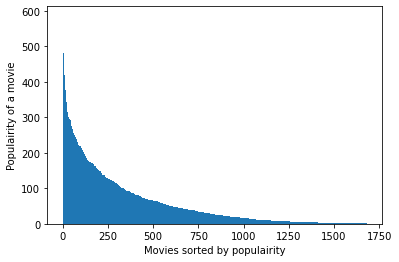

In [3]:
full_dataset = get_dataset(1)

A subsampled version of the MovieLens-100 dataset.

Dataset with subsampling ratio 8 has 12500 rankings provided by 933 users about 1297 items.


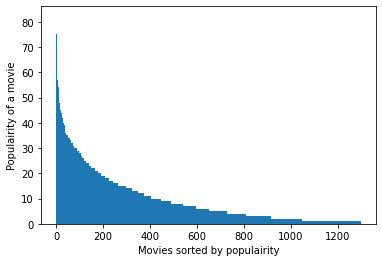

In [4]:
small_dataset = get_dataset(8)

The PureSVD recommender, which imputes all unknown rankings to be zero and then performs a Singular Value Decomposition.

In [5]:
class PureSVDRecommender:
    def __init__(self, n_components, dataset):
        self.n_components = n_components
        self.dataset = dataset

    def train(self, train_data, rng):
        train_rank_matrix = coo_matrix(
            (
                train_data[:, 2],
                (train_data[:, 0].astype(int), train_data[:, 1].astype(int)),
            )
        )

        self.U, self.Sigma, self.Qt = randomized_svd(
            train_rank_matrix, n_components=self.n_components
        )

    def get_scores(self, user_indices, item_indices):
        return self.U[user_indices, :] @ np.diag(self.Sigma) @ self.Qt[:, item_indices]

Gradient descent recommender, which minimizes equation (4) from the paper [Probabilistic Matrix Factorization](https://papers.nips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf) by R. Salakhutdinov and A. Mnih. Here, there is no imputation, i.e. the loss only incldues the known entries of the ranking matrix.

In [6]:
class GradientDescentRecommender:
    class SpectralBottleneck(torch.nn.Module):
        def __init__(self, n_components, dataset):
            super().__init__()
            self.user_features = Parameter(
                torch.rand((dataset.no_users, n_components), requires_grad=True)
                / np.sqrt(n_components)
            )
            self.item_features = Parameter(
                torch.rand((n_components, dataset.no_items), requires_grad=True)
                / np.sqrt(n_components)
            )

        def forward(self, user_indices, item_indices):
            user_item_product = (
                self.user_features[user_indices, :]
                @ self.item_features[:, item_indices]
            )
            return user_item_product

        def regularizer(self):
            return torch.norm(self.user_features) + torch.norm(self.item_features)

    def __init__(self, n_components, dataset, norm_penalty=1e-2):
        self.n_components = n_components
        self.norm_penalty = norm_penalty
        self.dataset = dataset
        self.spectral_bottleneck = GradientDescentRecommender.SpectralBottleneck(
            n_components, dataset
        )

    def train(self, train_data, rng):
        optimizer = torch.optim.Adam(self.spectral_bottleneck.parameters(), lr=5e-3)
        no_train_points = train_data.shape[0]
        loss_history = []
        for i in range(10000):
            optimizer.zero_grad()

            minibatch_indices = rng.choice(no_train_points, 128, replace=False)

            user_ids = train_data[minibatch_indices, 0].astype(int)
            item_ids = train_data[minibatch_indices, 1].astype(int)
            rankings = train_data[minibatch_indices, 2]

            rank_loss = 0
            for user_id, item_id, ranking in zip(user_ids, item_ids, rankings):
                rank_loss += (ranking - self.spectral_bottleneck(user_id, item_id)) ** 2
            rank_loss /= len(minibatch_indices)
            loss = (
                torch.sqrt(rank_loss)
                + self.norm_penalty * self.spectral_bottleneck.regularizer()
            )
            loss_history.append(float(loss.data))

            loss.backward()
            optimizer.step()

            if (
                i > 100
                and np.abs(
                    np.mean(np.array(loss_history[-10:]))
                    - np.mean(np.array(loss_history[-100:]))
                )
                < 1e-3
            ):
                break

        plt.plot(np.array(loss_history))

        plt.xlabel("Iteration")
        plt.ylabel("Training Loss")

    def get_scores(self, user_indices, item_indices):
        return self.spectral_bottleneck(user_indices, item_indices).data.numpy()

We use testing protocol from Cremonesi et al.: _Performance of Recommender Algorithms on Top-N Recommendation Tasks_

In [7]:
def separate_train_test(rng, dataset):
    no_datapoints = dataset.no_datapoints
    # 1.4% of dataset is used for testing
    no_probe_cases = np.floor(0.014 * no_datapoints).astype(int)  
    probe_indices = rng.choice(no_datapoints, size=no_probe_cases, replace=False)
    probe_mask = np.zeros((no_datapoints), dtype=bool)
    probe_mask[probe_indices] = True
    rank_5_mask = np.zeros((no_datapoints), dtype=bool)
    rank_5_mask[dataset.data[:, 2] == 5.0] = True
    test_mask = (
        rank_5_mask & probe_mask
    )  # items in test set have to be both in probe set and have a ranking of 5
    train_mask = ~test_mask
    return train_mask, test_mask


def run_experiment(seed, recommender):
    rng = np.random.RandomState(seed)
    dataset = recommender.dataset
    no_items = dataset.no_items
    train_mask, test_mask = separate_train_test(rng, dataset)
    no_test_cases = np.sum(test_mask)

    recommender.train(train_data=dataset.data[train_mask][:], rng=rng)

    test_data = dataset.data[test_mask, :]
    recall = np.zeros((1000))
    for i in range(no_test_cases):
        user_id = test_data[i, 0].astype(int)
        item_id = test_data[i, 1].astype(int)
        test_item_score = recommender.get_scores(user_id, item_id)
        other_item_ids = rng.choice(no_items, size=1000, replace=False)
        other_scores = recommender.get_scores(user_id, other_item_ids)
        greater_scores = np.sum(other_scores > test_item_score).astype(
            int
        )  # 0 if test item comes on top, 1000 in the worst-case
        recall[greater_scores:] += 1

    recall /= no_test_cases

    return recall

Run 3 random trials of each algorithm and obtain recall curves for the small dataset.

In [8]:
recall_curves_small_dataset_puresvd = [
    run_experiment(i, PureSVDRecommender(n_components=10, dataset=small_dataset))
    for i in range(3)
]

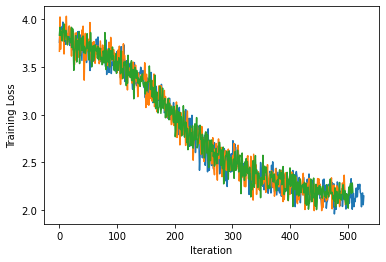

In [9]:
recall_curves_small_dataset_gd = [
    run_experiment(
        i,
        GradientDescentRecommender(
            n_components=10, dataset=small_dataset, norm_penalty=1e-2
        ),
    )
    for i in range(3)
]

Plot the recall curves for the small dataset, trying each of the two algorithms with three random seeds. See section 2 in Cremonesi et al.: _Performance of Recommender Algorithms on Top-N Recommendation Tasks_ for a definition of the x-axis.

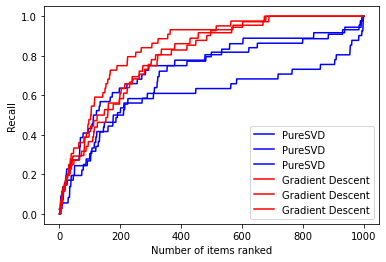

In [10]:
for recall_curve in recall_curves_small_dataset_puresvd:
    plt.plot(recall_curve, "b", label="PureSVD")

for recall_curve in recall_curves_small_dataset_gd:
    plt.plot(recall_curve, "r", label="Gradient Descent")

plt.xlabel("Number of items ranked")
plt.ylabel("Recall")
plt.legend()

Perform experiments on the full dataset.

In [11]:
recall_curves_full_dataset_puresvd = [
    run_experiment(i, PureSVDRecommender(n_components=20, dataset=full_dataset))
    for i in range(3)
]

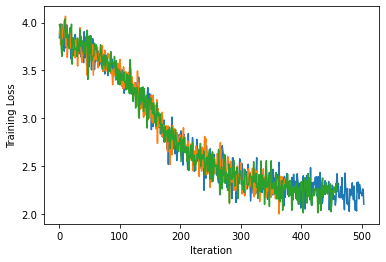

In [12]:
recall_curves_full_dataset_gd = [
    run_experiment(
        i,
        GradientDescentRecommender(
            n_components=20, dataset=full_dataset, norm_penalty=1e-2
        ),
    )
    for i in range(3)
]

Plot recall curves for the full dataset.

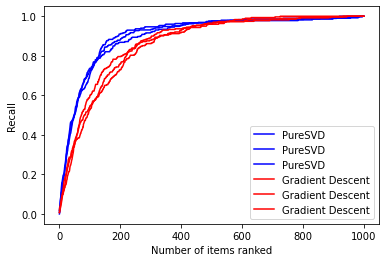

In [13]:
for recall_curve in recall_curves_full_dataset_puresvd:
    plt.plot(recall_curve, "b", label="PureSVD")

for recall_curve in recall_curves_full_dataset_gd:
    plt.plot(recall_curve, "r", label="Gradient Descent")

plt.xlabel("Number of items ranked")
plt.ylabel("Recall")
plt.legend()

The main takeway from these expriments is that gradient descent perfroms better on the small (very sparse) dataset, while PureSVD performs better on the relatively denser dataset. 